In [2]:
import networkx as nx

import numpy as np
import scipy.sparse as sparse
import cupy.sparse as cusparse

import torch
import matplotlib.pyplot as plt

import random as rnd
import pandas as pd
import time

In [2]:
# nx <= 22000
# cu <= 17000

# Gathering total time


In [5]:
# initial data                         
T = 75                                   
END_OF_TIMES = 1000000                     

infectious_lambda = 1/0.186 # распределение вейбула αˆ= and λˆ=
infectious_alpha = 1.24

removed_lambda = 16.5 # mean = 14.46 
removed_alpha = 2.5   # sd = 6

death_rate = 0.03
infectious_rate = 0.0258

cuda0 = torch.device('cuda')

results = pd.DataFrame(columns=['no_cuda','torch_cuda','graph_cuda','all_cuda'], index=[i for i in range(1000, 17001, 1000)])

## torch without cuda, graph on networkx

In [6]:
def no_cuda(pop):
  p_exposed    = int(pop * 0.1)       
  p_infectious = int(pop * 0.05)       
  p_removed    = 0                   



  nearest = 6
  density = 2 * nearest / (pop - 1)

  G = nx.watts_strogatz_graph(pop, nearest, 0.2) #4

  state = torch.zeros(pop)
  state[0:p_exposed] = 1
  state[p_exposed:p_exposed+p_infectious]=2
  state = state[torch.randperm(state.nelement())]

  tau = torch.full([pop], END_OF_TIMES)

  ei_distr = torch.distributions.Weibull(torch.tensor([infectious_lambda]), torch.tensor([infectious_alpha]))
  ir_distr = torch.distributions.Weibull(torch.tensor([removed_lambda]), torch.tensor([removed_alpha]))

  for t in range(T):
    
      Z = nx.fast_gnp_random_graph(pop, density)

      A = nx.adjacency_matrix(nx.compose(G, Z))

      AM = torch.tensor(A.todense())
      idx = (state == 1) & (tau == END_OF_TIMES)
      tau[idx] = torch.reshape(ei_distr.sample(tau[idx].size()).long(),(-1,)) + t

      idx = (state == 2) & (tau == END_OF_TIMES)
      tau[idx] = torch.reshape(ir_distr.sample(tau[idx].size()).long(),(-1,)) + t
      # print(tau)

      # Susceptible -> Exposed
      p = 1-(1-infectious_rate)**torch.sum((AM * (state==1)), dim=1)
      x = torch.rand(len(AM))
      idx = (x <= p) & (state==0)
      state[idx] = 1
      tau[idx] = END_OF_TIMES

      p = 1-(1-(infectious_rate/8))**torch.sum((AM * (state==2)), dim=1)
      x = torch.rand(len(AM))
      idx = (x <= p) & (state==0)
      state[idx] = 1
      tau[idx] = END_OF_TIMES

      # Exposed -> Infectious
      idx = (state == 1) & (tau == t)
      state[idx] = 2
      tau[idx] = END_OF_TIMES

      # Infectious -> Removed
      idx = (state == 2) & (tau == t)
      state[idx] = 3
      tau[idx] = END_OF_TIMES

  print(int(sum(state==0)),int(sum(state==1)),int(sum(state==2)),int(sum(state==3)))

## torch with cuda, graph on networkx

In [7]:
def torch_cuda(pop):
  p_exposed    = int(pop * 0.1)       
  p_infectious = int(pop * 0.05)       
  p_removed    = 0                   



  nearest = 6
  density = 2 * nearest / (pop - 1)


  G = nx.watts_strogatz_graph(pop, nearest, 0.2) #4

  state = torch.zeros(pop, device=cuda0)
  state[0:p_exposed] = 1
  state[p_exposed:p_exposed+p_infectious]=2
  state = state[torch.randperm(state.nelement(), device=cuda0)]

  tau = torch.full([pop], END_OF_TIMES, device=cuda0)

  ei_distr = torch.distributions.Weibull(torch.tensor([infectious_lambda], device=cuda0), torch.tensor([infectious_alpha], device=cuda0))
  ir_distr = torch.distributions.Weibull(torch.tensor([removed_lambda], device=cuda0), torch.tensor([removed_alpha], device=cuda0))

  for t in range(T):

      Z = nx.fast_gnp_random_graph(pop, density)

      GZ = nx.compose(G, Z)

      A = nx.adjacency_matrix(GZ)

      AM = torch.tensor(A.todense(), device=cuda0)
      idx = (state == 1) & (tau == END_OF_TIMES)
      tau[idx] = torch.reshape(ei_distr.sample(tau[idx].size()).long(),(-1,)) + t

      idx = (state == 2) & (tau == END_OF_TIMES)
      tau[idx] = torch.reshape(ir_distr.sample(tau[idx].size()).long(),(-1,)) + t
      # print(tau)

      # Susceptible -> Exposed
      p = 1-(1-infectious_rate)**torch.sum((AM * (state==1)), dim=1)
      x = torch.rand(len(AM), device=cuda0)
      idx = (x <= p) & (state==0)
      state[idx] = 1
      tau[idx] = END_OF_TIMES

      p = 1-(1-(infectious_rate/8))**torch.sum((AM * (state==2)), dim=1)
      x = torch.rand(len(AM), device=cuda0)
      idx = (x <= p) & (state==0)
      state[idx] = 1
      tau[idx] = END_OF_TIMES

      # Exposed -> Infectious
      idx = (state == 1) & (tau == t)
      state[idx] = 2
      tau[idx] = END_OF_TIMES

      # Infectious -> Removed
      idx = (state == 2) & (tau == t)
      state[idx] = 3
      tau[idx] = END_OF_TIMES

  print(int(sum(state==0)),int(sum(state==1)),int(sum(state==2)),int(sum(state==3)))

## torch without cuda, graph with cuda-scipy

In [12]:
def graph_cuda(pop):
  p_exposed    = int(pop * 0.1)       
  p_infectious = int(pop * 0.05)       
  p_removed    = 0                   



  nearest = 6
  density = 2 * nearest / (pop - 1)

  G = nx.watts_strogatz_graph(pop, nearest, 0.2) #4
  A = nx.to_scipy_sparse_matrix(G, dtype=np.float32)

  A = cusparse.csr_matrix(A)

  state = torch.zeros(pop)
  state[0:p_exposed] = 1
  state[p_exposed:p_exposed+p_infectious]=2
  state = state[torch.randperm(state.nelement())]

  tau = torch.full([pop], END_OF_TIMES)

  ei_distr = torch.distributions.Weibull(torch.tensor([infectious_lambda]), torch.tensor([infectious_alpha]))
  ir_distr = torch.distributions.Weibull(torch.tensor([removed_lambda]), torch.tensor([removed_alpha]))

  for t in range(T):


      B = cusparse.rand(pop, pop, density=density, format='csr', dtype=np.float32)
      B = B + B.T
      B.data[:] = 1
      

      AM = torch.tensor((A + B).todense())
      idx = (state == 1) & (tau == END_OF_TIMES)
      tau[idx] = torch.reshape(ei_distr.sample(tau[idx].size()).long(),(-1,)) + t

      idx = (state == 2) & (tau == END_OF_TIMES)
      tau[idx] = torch.reshape(ir_distr.sample(tau[idx].size()).long(),(-1,)) + t
      # print(tau)

      # Susceptible -> Exposed
      p = 1-(1-infectious_rate)**torch.sum((AM * (state==1)), dim=1)
      x = torch.rand(len(AM))
      idx = (x <= p) & (state==0)
      state[idx] = 1
      tau[idx] = END_OF_TIMES

      p = 1-(1-(infectious_rate/8))**torch.sum((AM * (state==2)), dim=1)
      x = torch.rand(len(AM))
      idx = (x <= p) & (state==0)
      state[idx] = 1
      tau[idx] = END_OF_TIMES

      # Exposed -> Infectious
      idx = (state == 1) & (tau == t)
      state[idx] = 2
      tau[idx] = END_OF_TIMES

      # Infectious -> Removed
      idx = (state == 2) & (tau == t)
      state[idx] = 3
      tau[idx] = END_OF_TIMES

      del B

  print(int(sum(state==0)),int(sum(state==1)),int(sum(state==2)),int(sum(state==3)))

## torch with cuda, graph with cuda-scipy

In [13]:
def all_cuda(pop):
  p_exposed    = int(pop * 0.1)       
  p_infectious = int(pop * 0.05)       
  p_removed    = 0                   



  nearest = 6
  density = 2 * nearest / (pop - 1)


  G = nx.watts_strogatz_graph(pop, nearest, 0.2) #4
  A = nx.to_scipy_sparse_matrix(G, dtype=np.float32)

  A = cusparse.csr_matrix(A)

  state = torch.zeros(pop, device=cuda0)
  state[0:p_exposed] = 1
  state[p_exposed:p_exposed+p_infectious]=2
  state = state[torch.randperm(state.nelement(), device=cuda0)]

  tau = torch.full([pop], END_OF_TIMES, device=cuda0)

  ei_distr = torch.distributions.Weibull(torch.tensor([infectious_lambda], device=cuda0), torch.tensor([infectious_alpha], device=cuda0))
  ir_distr = torch.distributions.Weibull(torch.tensor([removed_lambda], device=cuda0), torch.tensor([removed_alpha], device=cuda0))

  for t in range(T):


      B = cusparse.rand(pop, pop, density=density, format='csr', dtype=np.float32)
      B = B + B.T
      B.data[:] = 1
      

      AM = torch.tensor((A + B).todense(), device=cuda0)
      idx = (state == 1) & (tau == END_OF_TIMES)
      tau[idx] = torch.reshape(ei_distr.sample(tau[idx].size()).long(),(-1,)) + t

      idx = (state == 2) & (tau == END_OF_TIMES)
      tau[idx] = torch.reshape(ir_distr.sample(tau[idx].size()).long(),(-1,)) + t
      # print(tau)

      # Susceptible -> Exposed
      p = 1-(1-infectious_rate)**torch.sum((AM * (state==1)), dim=1)
      x = torch.rand(len(AM), device=cuda0)
      idx = (x <= p) & (state==0)
      state[idx] = 1
      tau[idx] = END_OF_TIMES

      p = 1-(1-(infectious_rate/8))**torch.sum((AM * (state==2)), dim=1)
      x = torch.rand(len(AM), device=cuda0)
      idx = (x <= p) & (state==0)
      state[idx] = 1
      tau[idx] = END_OF_TIMES

      # Exposed -> Infectious
      idx = (state == 1) & (tau == t)
      state[idx] = 2
      tau[idx] = END_OF_TIMES

      # Infectious -> Removed
      idx = (state == 2) & (tau == t)
      state[idx] = 3
      tau[idx] = END_OF_TIMES

      del B

  print(int(sum(state==0)),int(sum(state==1)),int(sum(state==2)),int(sum(state==3)))

# main


In [ ]:
if cuda0.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

In [ ]:
n = 5
for i in range(1000, 17001, 1000):
  #for fun in [no_cuda, torch_cuda, graph_cuda, all_cuda]:
  for fun in  [all_cuda]:
    print(f"{i}:{fun.__name__}")
    try:
      beg = time.perf_counter()
      for _ in range(n):
        fun(i)
      end = time.perf_counter()
      results[fun.__name__][i] = (end - beg) / n
    except Exception:
      print('some error')

In [ ]:
results

In [10]:
text_file = open("f.json", "w")
text_file.write(results.to_json())
text_file.close()

# show results


In [4]:
df = pd.read_json('f.json')
df

,no_cuda,torch_cuda,graph_cuda,all_cuda
1000,5.577327,5.605667,2.349542,1.754620
2000,14.540968,12.954593,3.961023,1.335633
3000,20.883131,17.556133,4.630087,2.241123
4000,30.958768,24.607735,7.883806,3.670711
5000,42.710044,32.654213,12.482012,5.551425
6000,56.031443,41.175750,16.773909,6.996483
7000,71.276131,50.759402,23.022793,9.215419
8000,86.877028,60.139646,29.302648,11.734574
9000,105.513303,72.095287,36.902230,14.572522
10000,125.661257,84.569773,44.277452,17.856879


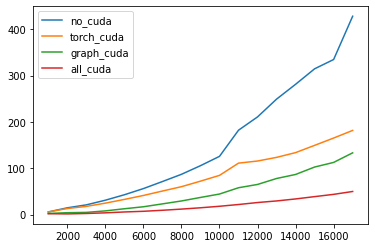

In [5]:
pd.read_json('f.json').plot()

In [6]:
df['no_cuda'] / df['all_cuda'] 

1000      3.178652
2000     10.886947
3000      9.318156
4000      8.433998
5000      7.693528
6000      8.008516
7000      7.734442
8000      7.403509
9000      7.240566
10000     7.037134
11000     8.417695
12000     8.133953
13000     8.490568
14000     8.352398
15000     8.137464
16000     7.683199
17000     8.600966
dtype: float64

In [7]:
(df['no_cuda'] / df['all_cuda']).mean()

7.926569980118638